<a href="https://colab.research.google.com/github/Shubangi-Saxena/Intent_Recognition_Shreya_Shubangi_Srushti/blob/main/Intent_recognition_SHREYA_SHUBANGI_SRUSHTI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 8.8 MB/s 
     |████████████████████████████████| 163 kB 54.0 MB/s 
     |████████████████████████████████| 7.6 MB 62.0 MB/s 


In [2]:
pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16182 sha256=1f35a37ee1c8b2db9062eee5c73b8f1bbfbe6552560ab2c0b1361d9711e872cf
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [3]:
import json
import pickle
import time
import datetime
import random
import os
import csv

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from seqeval.metrics import f1_score

import matplotlib.pyplot as plt 

device = torch.device("cpu")

SEED_VAL = 42

random.seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL);  # Semicolon prevents jupyter from displaying last line as output

In [4]:
SNIPS_PATH = "/content/"
TRAIN_PATH = f"{SNIPS_PATH}/train.tsv"
VAL_PATH = f"{SNIPS_PATH}/dev.tsv"
TEST_PATH = f"{SNIPS_PATH}/test.tsv"
df = pd.read_csv(TEST_PATH,sep='\t')

def load_snips_file(file_path):
    list_pair =[]
    with open(file_path,'r',encoding="utf8") as f:
        for line in f:
            split_line = line.split('\t')
            pair = split_line[0],split_line[1]
            list_pair.append(pair)
    return list_pair


In [5]:
all_train_examples = load_snips_file(TRAIN_PATH)
valid_examples = load_snips_file(VAL_PATH)
test_examples = load_snips_file(TEST_PATH)

In [6]:
intents = np.unique(np.array(all_train_examples)[:,0]).tolist()

intent_labeltoid = {intents[i]: i  for i in range(len(intents))}
intent_labeltoid

{'AddToPlaylist': 0,
 'BookRestaurant': 1,
 'GetWeather': 2,
 'PlayMusic': 3,
 'RateBook': 4,
 'SearchCreativeWork': 5,
 'SearchScreeningEvent': 6}

In [7]:
#How many training examples are there for each intent?
intent_series = pd.Series(np.array(all_train_examples)[:,0])
intent_series.value_counts()

PlayMusic               1914
GetWeather              1896
BookRestaurant          1881
RateBook                1876
SearchScreeningEvent    1852
SearchCreativeWork      1847
AddToPlaylist           1818
dtype: int64

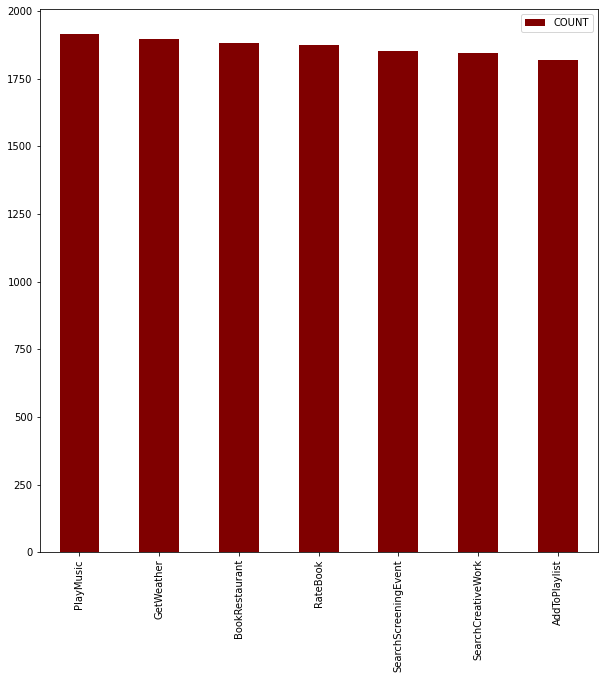

In [8]:
#plot for train data
df_train = pd.DataFrame(intent_series.value_counts())
df_train.rename(columns = {0:'COUNT'}, inplace = True)
df_train.plot.bar(color="maroon",figsize=(10,10))
plt.show()

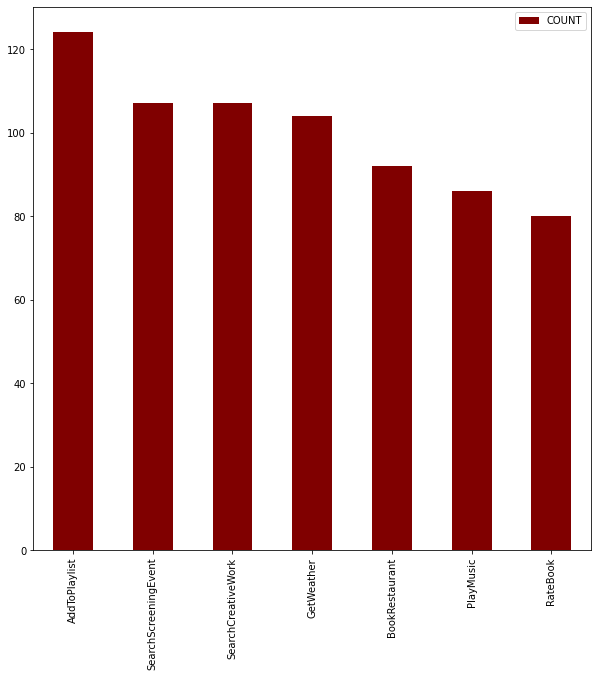

In [9]:
intent_series_test = pd.Series(np.array(test_examples)[:,0])
# intent_series_valid= pd.Series(np.array(valid_examples)[:,0])
#plot for train data
df_test = pd.DataFrame(intent_series_test.value_counts())
df_test.rename(columns = {0:'COUNT'}, inplace = True)
df_test.plot.bar(color="maroon",figsize=(10,10))
plt.show()

In [10]:
data=pd.DataFrame(all_train_examples)
data.rename(columns = {0:'LABEL',1:"TEXT"}, inplace = True)
# intent_labeltoid = {intents[i]: i  for i in range(len(intents))}
data['LABEL'].replace(['AddToPlaylist', 'BookRestaurant', 'GetWeather',
                       'PlayMusic', 'RateBook', 'SearchCreativeWork','SearchScreeningEvent']
                      ,[0,1,2,3,4,5,6],inplace=True)
data

,LABEL,TEXT
0,3,listen to westbam alumb allergic on google music
1,0,add step to me to the 50 clásicos playlist
2,4,i give this current textbook a rating value of...
3,3,play the song little robin redbreast
4,0,please add iris dement to my playlist this is ...
...,...,...
13079,1,i want to eat choucroute at a brasserie for 8
13080,3,play funky heavy bluesy
13081,4,rate the current album 2 points out of 6
13082,5,go to the photograph the inflated tear


In [11]:
data_test=pd.DataFrame(test_examples)
data_test.rename(columns = {0:'LABEL',1:"TEXT"}, inplace = True)
# intent_labeltoid = {intents[i]: i  for i in range(len(intents))}
data_test['LABEL'].replace(['AddToPlaylist', 'BookRestaurant', 'GetWeather',
                       'PlayMusic', 'RateBook', 'SearchCreativeWork','SearchScreeningEvent']
                      ,[0,1,2,3,4,5,6],inplace=True)
data_test

,LABEL,TEXT
0,0,add sabrina salerno to the grime instrumentals...
1,1,i want to bring four people to a place that s ...
2,0,put lindsey cardinale into my hillary clinton ...
3,2,will it snow in mt on june 13 2038
4,3,play signe anderson chant music that is newest
...,...,...
695,5,find a tv series called armageddon summer
696,5,find politicsnation with al sharpton
697,4,rate this album 0 points out of 6
698,0,add leah kauffman to my uncharted 4 nathan dra...


In [12]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
#SVM
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def text_preprocessing(text):
    # Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
    text = text.lower()

    # Tokenization : In this each entry in the corpus will be broken into set of words
    text_words_list = word_tokenize(text)

    # Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(text_words_list):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
        # The final processed set of words for each iteration will be stored in 'text_final'
    return str(Final_words)
data['text_final'] = data['TEXT'].map(text_preprocessing)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(data['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(data['TEXT'])
Test_X_Tfidf = Tfidf_vect.transform(data_test['TEXT'])

In [15]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
from sklearn.multiclass import OneVsRestClassifier
SVM = svm.SVC(C=1.0, kernel='linear', gamma='auto')
SVM=OneVsRestClassifier(SVM)
SVM.fit(Train_X_Tfidf, data['LABEL'])

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, data_test['LABEL']) * 100)


SVM Accuracy Score ->  96.42857142857143


In [16]:
#Algorithm Naive Bayes
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf, data['LABEL'])

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ", accuracy_score(predictions_NB, data_test['LABEL']) * 100)

Naive Bayes Accuracy Score ->  96.0


In [17]:
from sklearn.ensemble import RandomForestClassifier

#Algorithm Random forest
rfc = RandomForestClassifier(bootstrap=True,
                              max_depth=10,
                              max_features='sqrt',
                              random_state=1,n_estimators=100
                             )

rfc.fit(Train_X_Tfidf, data['LABEL'])

predictions_rfc = rfc.predict(Test_X_Tfidf)

print("Random forest Accuracy Score -> ", accuracy_score(predictions_rfc, data_test['LABEL']) * 100)

Random forest Accuracy Score ->  93.0


In [18]:
import sklearn
f1_svm=sklearn.metrics.f1_score(predictions_SVM,data_test['LABEL'],average="micro")
# ,precision_svm,recall_svm=get_f1score(predictions_SVM,data_test['LABEL'])
f1_rfc=sklearn.metrics.f1_score(predictions_rfc,data_test['LABEL'],average="micro")
f1_NB=sklearn.metrics.f1_score(predictions_NB,data_test['LABEL'],average="micro")

print("F1 score (SVM): ",f1_svm)
print("F1 score(Random Forest Classifiers):",f1_rfc)
print("F1 score(Naive Bayes):",f1_NB)

F1 score (SVM):  0.9642857142857143
F1 score(Random Forest Classifiers): 0.93
F1 score(Naive Bayes): 0.96


In [19]:
import sklearn
precision_svm=sklearn.metrics.precision_score(predictions_SVM,data_test['LABEL'],average="micro")
# ,precision_svm,recall_svm=get_f1score(predictions_SVM,data_test['LABEL'])
precision_rfc=sklearn.metrics.precision_score(predictions_rfc,data_test['LABEL'],average="micro")
precision_NB=sklearn.metrics.precision_score(predictions_NB,data_test['LABEL'],average="micro")

recall_svm=sklearn.metrics.recall_score(predictions_SVM,data_test['LABEL'],average="micro")
# ,precision_svm,recall_svm=get_f1score(predictions_SVM,data_test['LABEL'])
recall_rfc=sklearn.metrics.recall_score(predictions_rfc,data_test['LABEL'],average="micro")
recall_NB=sklearn.metrics.recall_score(predictions_NB,data_test['LABEL'],average="micro")

print("Precision score (SVM): ",precision_svm)
print("Precision score(Random Forest Classifiers):",precision_rfc)
print("Precision score(Naive Bayes):",precision_NB)

print("Recall score (SVM): ",recall_svm)
print("Recall score(Random Forest Classifiers):",recall_rfc)
print("Recall score(Naive Bayes):",recall_NB)

Precision score (SVM):  0.9642857142857143
Precision score(Random Forest Classifiers): 0.93
Precision score(Naive Bayes): 0.96
Recall score (SVM):  0.9642857142857143
Recall score(Random Forest Classifiers): 0.93
Recall score(Naive Bayes): 0.96


## Creating Mini-Training Sets



In [20]:
def create_mini_training_set(examples_per_intent):
    intent_array = np.array(all_train_examples)[:,0]
    mini_batch =[]
    for intent in intents:
        add = intent_array[intent_array==intent]
        shuffled_indicies=np.random.RandomState(seed=42).permutation(len(add))
        class_indicies=shuffled_indicies[:examples_per_intent]
        sampled_set = np.array(all_train_examples)[class_indicies]
        mini_batch.append(sampled_set)
    mini_batch = np.array(mini_batch)
    mini_set = mini_batch.transpose(1,0,2).reshape(-1,mini_batch.shape[2])
    return mini_set

In [21]:
import re
def get_pad_length():
    all_train_examples_sentences = np.array(all_train_examples)[:,1]
    word_length = []
    for sentence in all_train_examples_sentences: 
        number_words = len(re.findall(r'\w+',sentence))
        word_length.append(number_words)
        # print(word_length)
        # print(sentence)
        # print(number_words)
        # break
    return max(word_length)

PAD_LEN = get_pad_length() 
print(PAD_LEN)

35


In [22]:
INTENT_DIM = 7

## BERT Tokenizer


In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

test_utterance = "Alyssa told Ben the error of his ways"

print(tokenizer.encode_plus(
            test_utterance, add_special_tokens=True, max_length=PAD_LEN, pad_to_max_length=True, 
            truncation=True, return_attention_mask=True, return_tensors='pt'
    ))


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

{'input_ids': tensor([[  101, 26442,  2409,  3841,  1996,  7561,  1997,  2010,  3971,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [24]:
def examples_to_dataset(examples):
    input_ids = []
    attention_masks = []
    labels = []
    for instance in examples:
        token_dict = tokenizer.encode_plus(
                instance[1], add_special_tokens=True, max_length=PAD_LEN, pad_to_max_length=True, 
                truncation=True, return_attention_mask=True, return_tensors='pt')
        input_ids.append(token_dict['input_ids'])
        attention_masks.append(token_dict['attention_mask'])
        labels.append(torch.tensor(intent_labeltoid[instance[0]]).type(torch.LongTensor))
    # print(labels)
    # print(intent_labeltoid[instance[0]])
    input_ids = torch.cat(input_ids)
    attention_masks = torch.cat(attention_masks)
    labels = torch.stack(labels)
    # print(labels)

    dataset = TensorDataset(input_ids, attention_masks, labels)
    
    return dataset

In [25]:
#prepare the validation/test dataloaders 
val_dataset = examples_to_dataset(valid_examples)
test_dataset = examples_to_dataset(test_examples)
BATCH_SIZE = 50
validation_dataloader = DataLoader(val_dataset, sampler=RandomSampler(val_dataset), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=BATCH_SIZE)

In [26]:
def get_accuracy(preds, labels):
    pred_convd = np.argmax(preds,1).flatten()
    labels_flat = labels.flatten()
    correct_labels = np.equal(pred_convd,labels_flat).sum()
    accuracy_value = correct_labels/len(labels)
    return accuracy_value

In [27]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 14.6 MB/s 


In [28]:
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.functional import precision_recall
def get_f1score(preds,labels):
  metric = MulticlassF1Score(num_classes=7)
  f1_score=metric(preds, labels)
  precision,recall=precision_recall(preds, labels, average='micro', num_classes=7)
  return f1_score,precision,recall

In [29]:
# Quick tests for the implementation of accuracy.

preds1 = np.array([[1,2,3], [1,3,2], [3,2,1]])

assert get_accuracy(preds1, np.array([2,1,0])) == 1.0
assert get_accuracy(preds1, np.array([2,2,0])) == 2/3
assert get_accuracy(preds1, np.array([3,2,1])) == 0.0

In [30]:
count=0
# print(list(test_dataloader))
for batch in tqdm(list(test_dataloader)):
    a,b,c= batch[0],batch[1],batch[2]
    count+=1
    if count ==1:
        break
print(a);print(b);print(c)
print(batch)
print(len(list(test_dataloader)))

  0%|          | 0/14 [00:00<?, ?it/s]

tensor([[  101,  5587, 21876,  ...,     0,     0,     0],
        [  101,  1045,  2215,  ...,     0,     0,     0],
        [  101,  2404, 17518,  ...,     0,     0,     0],
        ...,
        [  101,  3446,  1996,  ...,     0,     0,     0],
        [  101,  2338,  1037,  ...,     0,     0,     0],
        [  101,  2338,  1037,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([0, 1, 0, 2, 3, 6, 1, 2, 6, 1, 6, 5, 6, 1, 5, 2, 5, 1, 6, 1, 4, 0, 0, 6,
        2, 2, 6, 1, 3, 0, 0, 4, 3, 6, 0, 5, 4, 6, 2, 2, 3, 4, 3, 2, 3, 2, 3, 4,
        1, 1])
[tensor([[  101,  5587, 21876,  ...,     0,     0,     0],
        [  101,  1045,  2215,  ...,     0,     0,     0],
        [  101,  2404, 17518,  ...,     0,     0,     0],
        ...,
        [  101,  3446,  1996,  ...,     0,     0,     0],

In [31]:
def evaluate(model, dataloader):
    model.eval()

    accuracy=[]
    precision=[]
    recall=[]
    f1_score=[]

    for batch in tqdm(list(dataloader)):
        b_input_ids,b_input_mask,b_labels = batch
        
        
        with torch.no_grad():
            (loss, logits) = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels, return_dict=False)
        batch_f1_score,batch_precision,batch_recall=get_f1score(logits,b_labels)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #logit_probability =torch.nn.Softmax(logits)
        batch_accuracy = get_accuracy(logits, label_ids)
        # batch_f1_score,batch_precision,batch_recall=get_f1score(logits,label_ids)
        accuracy.append(batch_accuracy)
        precision.append(batch_precision)
        recall.append(batch_recall)
        f1_score.append(batch_f1_score)
    avg_accuracy = np.mean(accuracy)  # TODO Compute final accuracy
    avg_recall=np.mean(recall)
    avg_f1_score=np.mean(f1_score)
    avg_precision=np.mean(precision)
    print("Validation Accuracy: {}".format(avg_accuracy))  
    print("Validation F1 score: {}".format(avg_f1_score))   
    print("Validation precision: {}".format(avg_precision))
    print("Validation recall: {}".format(avg_recall))
    return avg_accuracy,avg_f1_score,avg_precision,avg_recall      

In [32]:
#Correct one
accuracy_epoch=[]
loss_epoch=[]
def train(model, dataloader, epochs):
    optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)   #lr was 2e-5
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    
   
    for epoch_i in range(0, EPOCHS):
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

        model.train()
        accuracy = []
        total_train_loss = []
        
        for step, batch in tqdm(list(enumerate(train_dataloader))):
            # get input IDs, input mask, and labels from batch
            b_input_ids,b_input_mask,b_labels = batch

            model.zero_grad()
            #pass inputs through model
            (loss, logits) = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels, return_dict=False)
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # print(logits)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            # Add to total_train_loss
            total_train_loss.append(loss)
            #logit_probability =torch.nn.Softmax(logits)
            batch_accuracy = get_accuracy(logits, label_ids)
            accuracy.append(batch_accuracy)
            #n_iteration += 1
        # Compute average train loss
        new_loss = [x.cpu().detach().numpy() for x in total_train_loss]
        avg_train_loss = np.mean(new_loss) 
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Average Training accuracy: {0:.2f}".format(np.mean(accuracy)))
        accuracy_epoch.append(np.mean(accuracy))
        loss_epoch.append(avg_train_loss)
    


In [33]:
BATCH_SIZE = 16

EPOCHS = 5
EXAMPLES_PER_INTENT = 250

mini_train_set = examples_to_dataset(create_mini_training_set(EXAMPLES_PER_INTENT))

train_dataloader = DataLoader(mini_train_set, sampler=RandomSampler(mini_train_set), batch_size=BATCH_SIZE)


bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = INTENT_DIM,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


train(bert_model, train_dataloader, EPOCHS)

print("Evaluating on test set:")
print("Test accuracy:", evaluate(bert_model, test_dataloader))

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 5 ========


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/110 [00:00<?, ?it/s]

  Average training loss: 1.47
  Average Training accuracy: 0.57
======== Epoch 2 / 5 ========


  0%|          | 0/110 [00:00<?, ?it/s]

  Average training loss: 0.51
  Average Training accuracy: 0.97
======== Epoch 3 / 5 ========


  0%|          | 0/110 [00:00<?, ?it/s]

  Average training loss: 0.16
  Average Training accuracy: 0.99
======== Epoch 4 / 5 ========


  0%|          | 0/110 [00:00<?, ?it/s]

  Average training loss: 0.07
  Average Training accuracy: 0.99
======== Epoch 5 / 5 ========


  0%|          | 0/110 [00:00<?, ?it/s]

  Average training loss: 0.04
  Average Training accuracy: 1.00
Evaluating on test set:


  0%|          | 0/14 [00:00<?, ?it/s]

Validation Accuracy: 0.9585714285714287
Validation F1 score: 0.959184467792511
Validation precision: 0.9585714936256409
Validation recall: 0.9585714936256409
Test accuracy: (0.9585714285714287, 0.95918447, 0.9585715, 0.9585715)


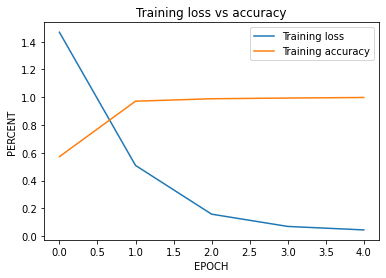

In [34]:
epochs=list(range(0,100))
plt.plot(epochs[0:5], loss_epoch,label="Training loss")
plt.plot(epochs[0:5],accuracy_epoch,label="Training accuracy")
plt.ylabel("PERCENT")
plt.xlabel("EPOCH")
plt.title("Training loss vs accuracy")
plt.legend()
plt.show()

In [35]:
print("Evaluating on test set:")
test_acc,test_f1,test_precision1,test_recall1=evaluate(bert_model, test_dataloader)
print("Test accuracy:", test_acc)
print("Test f1_score:",test_f1)
print("Test precision:",test_precision1)
print("Test recall:",test_recall1)

Evaluating on test set:


  0%|          | 0/14 [00:00<?, ?it/s]

Validation Accuracy: 0.9585714285714287
Validation F1 score: 0.959184467792511
Validation precision: 0.9585714936256409
Validation recall: 0.9585714936256409
Test accuracy: 0.9585714285714287
Test f1_score: 0.95918447
Test precision: 0.9585715
Test recall: 0.9585715


In [36]:
# Test accuracy results per examples per intent

test_accuracies = {
    1: 0.27,
    5: 0.3157142857142857,
    10: 0.4471428571428572,
    25: 0.7314285714285715,
    50: 0.8471428571428571,
    100: 0.9500000000000001,
    250: 0.9614285714285715
}

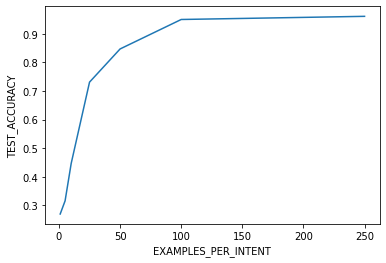

In [37]:
# A Plot of the final test accuracies as a function of EXAMPLES_PER_INTENT.
import seaborn as sns
for accuracy in test_accuracies:
  test_accuracies[accuracy] = np.round(test_accuracies[accuracy],3)

test_accuracies

ax = sns.lineplot(
    data=test_accuracies,
    x=list(test_accuracies.keys()), y=list(test_accuracies.values()),
    markers=True)
ax.set(xlabel='EXAMPLES_PER_INTENT', ylabel='TEST_ACCURACY')
plt.show()

In [38]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 14.1 MB/s 
     |████████████████████████████████| 2.3 MB 56.9 MB/s 
     |████████████████████████████████| 56 kB 5.6 MB/s 
     |████████████████████████████████| 106 kB 74.8 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
     |████████████████████████████████| 272 kB 73.0 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 54 kB 4.0 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 213 kB 71.0 MB/s 
     |████████████████████████████████| 64 kB 3.1 MB/s 
     |████████████████████████████████| 80 kB 11.5 MB/s 
     |████████████████████████████████| 68 kB 7.9 MB/s 
     |████████████████████████████████| 46 kB 5.3 MB/s 
     |████████████████████████████████| 593 kB 71.6 MB/s 
     |████████████████████████████████| 856 kB 

In [39]:
def evaluate_gradio(model, dataloader):
    model.eval()

    # accuracy=[]

    for batch in tqdm(list(dataloader)):
        b_input_ids,b_input_mask = batch
        
        
        with torch.no_grad():
            # (loss, logits) 
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   )

        logits = output.logits.detach().cpu()#.numpy()
        # label_ids = b_labels.to('cpu').numpy()

        #logit_probability =torch.nn.Softmax(logits)
        big_val,big_idx=torch.max(logits,dim=1)
        for i in big_idx:
          return i,logits

    # return logits


In [40]:
import gradio as gr
import tensorflow as tf 
def generate_txt(command):  
  input_ids = []
  attention_masks = []
  labels = []
  token_dict = tokenizer.encode_plus(
                command, add_special_tokens=True, max_length=PAD_LEN, pad_to_max_length=True, 
                truncation=True, return_attention_mask=True, return_tensors='pt')
  input_ids.append(token_dict['input_ids'])
  attention_masks.append(token_dict['attention_mask'])
  # labels.append(torch.tensor(intent_labeltoid[instance[0]]).type(torch.LongTensor))
  input_ids = torch.cat(input_ids)
  attention_masks = torch.cat(attention_masks)
  # labels = torch.stack(labels)
  dataset = TensorDataset(input_ids, attention_masks)
  
  test_loader = DataLoader(
      dataset,
      shuffle=False
    )
  beam_output,print_val=evaluate_gradio(bert_model,test_loader)
  
  if beam_output==torch.tensor(0):
    return "Add to Playlist"
  elif beam_output==torch.tensor(1):
    return "Book Restaurant"
  elif beam_output==torch.tensor(2):
    return "Get weather"
  elif beam_output==torch.tensor(3): 
    return "Play music"  
  elif beam_output==torch.tensor(4):
    return "Rate book"
  elif beam_output==torch.tensor(5):
    return "Search Creative Work"
  elif beam_output==torch.tensor(6):
    return "Search screening event"
    
  

In [ ]:
#with audio

!pip install SpeechRecognition pydub

import speech_recognition as sr
from transformers import pipeline

def generate_txt_google(command): 
  r=sr.Recognizer()
  with sr.AudioFile(command) as source:
    audio_data=r.record(source)
    text=r.recognize_google(audio_data)
  command=text 
  print(command)
  input_ids = []
  attention_masks = []
  labels = []
  token_dict = tokenizer.encode_plus(
                command, add_special_tokens=True, max_length=PAD_LEN, pad_to_max_length=True, 
                truncation=True, return_attention_mask=True, return_tensors='pt')
  input_ids.append(token_dict['input_ids'])
  attention_masks.append(token_dict['attention_mask'])
  # labels.append(torch.tensor(intent_labeltoid[instance[0]]).type(torch.LongTensor))
  input_ids = torch.cat(input_ids)
  attention_masks = torch.cat(attention_masks)
  # labels = torch.stack(labels)
  dataset = TensorDataset(input_ids, attention_masks)
  
  test_loader = DataLoader(
      dataset,
      shuffle=False
    )
  beam_output,print_val=evaluate_gradio(bert_model,test_loader)
  
  if beam_output==torch.tensor(0):
    return "Add to Playlist"
  elif beam_output==torch.tensor(1):
    return "Book Restaurant"
  elif beam_output==torch.tensor(2):
    return "Get weather"
  elif beam_output==torch.tensor(3): 
    return "Play music"  
  elif beam_output==torch.tensor(4):
    return "Rate book"
  elif beam_output==torch.tensor(5):
    return "Search Creative Work"
  elif beam_output==torch.tensor(6):
    return "Search screening event"

output_text=gr.outputs.Textbox()
gr.Interface(
    generate_txt_google,gr.Audio(source="microphone", type="filepath"),output_text,title="INTENT DETECTION",description="A model which detects intent in text\n").launch(debug=True)


 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 112 kB/s 


/usr/local/lib/python3.7/dist-packages/gradio/outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().

Using Embedded Colab Mode (NEW). If you have issues, please use share=True and file an issue at https://github.com/gradio-app/gradio/
Note: opening the browser inspector may crash Embedded Colab Mode.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/gradio/processing_utils.py:230: UserWarning: Trying to convert audio automatically from int32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


can you show me some pine artwork


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gradio/processing_utils.py:230: UserWarning: Trying to convert audio automatically from int32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


it seems we'll have heavy rain today


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gradio/processing_utils.py:230: UserWarning: Trying to convert audio automatically from int32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


I'm in a mood to have Chinese food


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gradio/processing_utils.py:230: UserWarning: Trying to convert audio automatically from int32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


listen to Bollywood songs


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gradio/processing_utils.py:230: UserWarning: Trying to convert audio automatically from int32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


distract should be president the playlist when travelling


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gradio/processing_utils.py:230: UserWarning: Trying to convert audio automatically from int32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


in contrast to the previous one I like Sidney Sheldon season 10 edition of The Book very much


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gradio/processing_utils.py:230: UserWarning: Trying to convert audio automatically from int32 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


I want to see the timings of Shahrukh Khan's show in Canada next month


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#With a text
output_text=gr.outputs.Textbox()
gr.Interface(
    generate_txt,["textbox"],output_text,title="INTENT DETECTION",description="A model which detects intent in text\n").launch(debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().

Using Embedded Colab Mode (NEW). If you have issues, please use share=True and file an issue at https://github.com/gradio-app/gradio/
Note: opening the browser inspector may crash Embedded Colab Mode.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7fe83a5259d0>, 'http://127.0.0.1:7860/', None)

NameError: ignored